# Imports

In [120]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

# Understanding the Data
In this section, we aim to better understand the data through a series of visualizations.

## 1. Shelter Occupancy Data

In [121]:
file_paths = ['/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2021.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2022.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2023.csv']

dataframes = [pd.read_csv(file) for file in file_paths]

for file in file_paths:
    try:
        df = pd.read_csv(file)
        if df.empty:
            print(f"The file at {file} is empty.")
        else:
            print(f"Loaded {len(df)} rows from {file}")
            dataframes.append(df)
    except FileNotFoundError:
        print(f"No file found at {file}")
    except pd.errors.EmptyDataError:
        print(f"File at {file} is empty or corrupted.")

if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"The combined dataframe has {len(combined_df)} rows.")
else:
    print("No data has been loaded. Please check the file paths and contents.")

Loaded 50944 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2021.csv
Loaded 49478 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2022.csv
Loaded 48345 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2023.csv
The combined dataframe has 297534 rows.


In [122]:
# COLUMN SELECTION -------------------------------------------------------------

combined_df = combined_df.dropna(subset=['CAPACITY_TYPE'])

# Separate data based on Capacity Type --> Bed Based and Room Based
bed_capacity_df = combined_df[combined_df['CAPACITY_TYPE'] == 'Bed Based Capacity'].copy()
room_capacity_df = combined_df[combined_df['CAPACITY_TYPE'] == 'Room Based Capacity'].copy()

# Removing unnecessary columns
columns_to_drop = ['_id', 'SHELTER_ID', 'PROGRAM_ID', 'SECTOR', 'PROGRAM_MODEL', 'SERVICE_USER_COUNT', 'OVERNIGHT_SERVICE_TYPE', 'PROGRAM_AREA', 'ORGANIZATION_NAME', 'SHELTER_GROUP', 'LOCATION_NAME', 'LOCATION_ADDRESS', 'LOCATION_CITY', 'LOCATION_PROVINCE', 'PROGRAM_NAME']
bed_columns_to_drop = ['CAPACITY_ACTUAL_ROOM', 'CAPACITY_FUNDING_ROOM', 'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS', 'OCCUPANCY_RATE_ROOMS']
room_columns_to_drop = ['CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS', 'OCCUPANCY_RATE_BEDS']

bed_capacity_df = bed_capacity_df.drop(columns_to_drop, axis=1)
bed_capacity_df = bed_capacity_df.drop(bed_columns_to_drop, axis=1)

room_capacity_df = room_capacity_df.drop(columns_to_drop, axis=1)
room_capacity_df = room_capacity_df.drop(room_columns_to_drop, axis=1)

# DATA PREPROCESSING -----------------------------------------------------------

# Convert OCCUPANCY_DATE to datetime
bed_capacity_df['OCCUPANCY_DATE'] = pd.to_datetime(bed_capacity_df['OCCUPANCY_DATE'],format='mixed')
room_capacity_df['OCCUPANCY_DATE'] = pd.to_datetime(room_capacity_df['OCCUPANCY_DATE'],format='mixed')

# Extract year, month, and day as separate features
bed_capacity_df['YEAR'] = bed_capacity_df['OCCUPANCY_DATE'].dt.year
bed_capacity_df['MONTH'] = bed_capacity_df['OCCUPANCY_DATE'].dt.month
bed_capacity_df['DAY'] = bed_capacity_df['OCCUPANCY_DATE'].dt.day

room_capacity_df['YEAR'] = room_capacity_df['OCCUPANCY_DATE'].dt.year
room_capacity_df['MONTH'] = room_capacity_df['OCCUPANCY_DATE'].dt.month
room_capacity_df['DAY'] = room_capacity_df['OCCUPANCY_DATE'].dt.day

print(bed_capacity_df.head())
print(room_capacity_df.head())

   OCCUPANCY_DATE  ORGANIZATION_ID  LOCATION_ID LOCATION_POSTAL_CODE  \
5      2021-01-01               24       1051.0              M5S 2P1   
10     2021-01-01               14       1029.0              M6H 3Z5   
11     2021-01-01               14       1102.0              M6G 1M2   
21     2021-01-01                1       1009.0              M3M 2X4   
25     2021-01-01                1       1065.0              M1E 2M6   

         CAPACITY_TYPE  CAPACITY_ACTUAL_BED  CAPACITY_FUNDING_BED  \
5   Bed Based Capacity                  8.0                   8.0   
10  Bed Based Capacity                 24.0                  33.0   
11  Bed Based Capacity                 12.0                  15.0   
21  Bed Based Capacity                 12.0                  12.0   
25  Bed Based Capacity                 12.0                  20.0   

    OCCUPIED_BEDS  UNOCCUPIED_BEDS  UNAVAILABLE_BEDS  OCCUPANCY_RATE_BEDS  \
5             6.0              2.0               0.0                75.00  

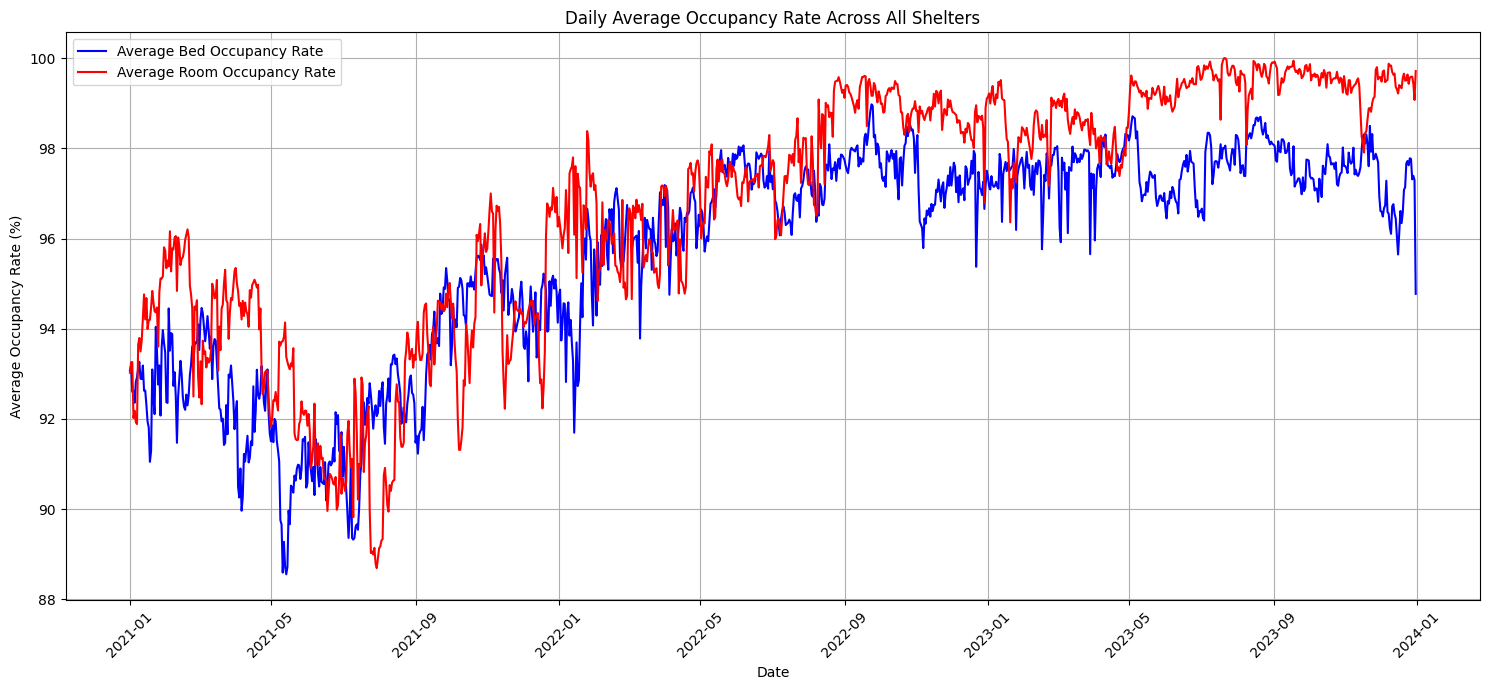

In [123]:
# PLOTTING AVERAGE DEMAND TO VISUALIZE -----------------------------------------

# Calculate daily average occupancy rate for beds
daily_avg_bed_occupancy = bed_capacity_df.groupby('OCCUPANCY_DATE')['OCCUPANCY_RATE_BEDS'].mean().reset_index()

# Calculate daily average occupancy rate for rooms
daily_avg_room_occupancy = room_capacity_df.groupby('OCCUPANCY_DATE')['OCCUPANCY_RATE_ROOMS'].mean().reset_index()

# Plotting
plt.figure(figsize=(15, 7))

# Plot for beds
plt.plot(daily_avg_bed_occupancy['OCCUPANCY_DATE'], daily_avg_bed_occupancy['OCCUPANCY_RATE_BEDS'], label='Average Bed Occupancy Rate', color='blue')

# Plot for rooms
plt.plot(daily_avg_room_occupancy['OCCUPANCY_DATE'], daily_avg_room_occupancy['OCCUPANCY_RATE_ROOMS'], label='Average Room Occupancy Rate', color='red')

plt.title('Daily Average Occupancy Rate Across All Shelters')
plt.xlabel('Date')
plt.ylabel('Average Occupancy Rate (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()

plt.show()

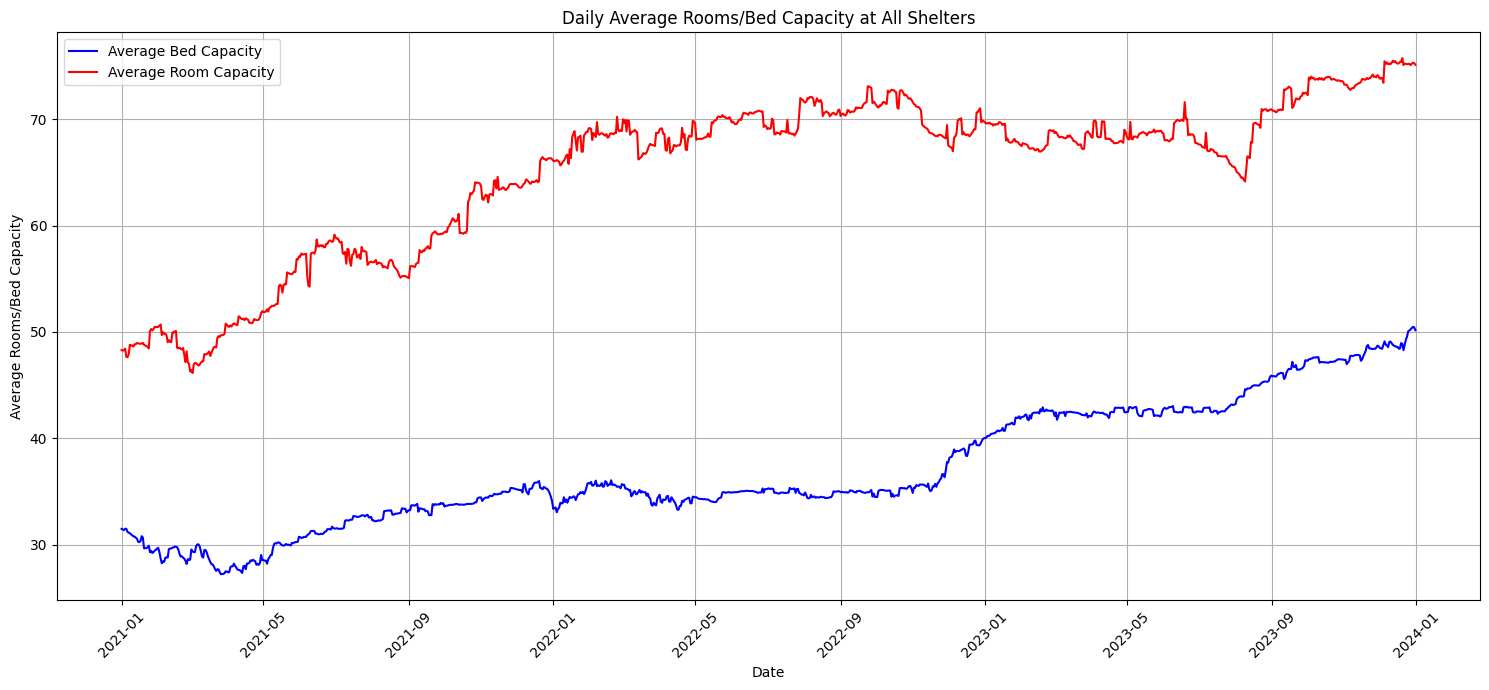

In [124]:
# PLOTTING AVAILABILITY TO VISUALIZE -----------------------------------------

# Calculate daily average occupancy rate for beds
daily_avg_bed_avail = bed_capacity_df.groupby('OCCUPANCY_DATE')['CAPACITY_ACTUAL_BED'].mean().reset_index()

# Calculate daily average occupancy rate for rooms
daily_avg_room_avail = room_capacity_df.groupby('OCCUPANCY_DATE')['CAPACITY_ACTUAL_ROOM'].mean().reset_index()

# Plotting
plt.figure(figsize=(15, 7))

# Plot for beds
plt.plot(daily_avg_bed_avail['OCCUPANCY_DATE'], daily_avg_bed_avail['CAPACITY_ACTUAL_BED'], label='Average Bed Capacity', color='blue')

# Plot for rooms
plt.plot(daily_avg_room_avail['OCCUPANCY_DATE'], daily_avg_room_avail['CAPACITY_ACTUAL_ROOM'], label='Average Room Capacity', color='red')

plt.title('Daily Average Rooms/Bed Capacity at All Shelters')
plt.xlabel('Date')
plt.ylabel('Average Rooms/Bed Capacity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()

plt.show()

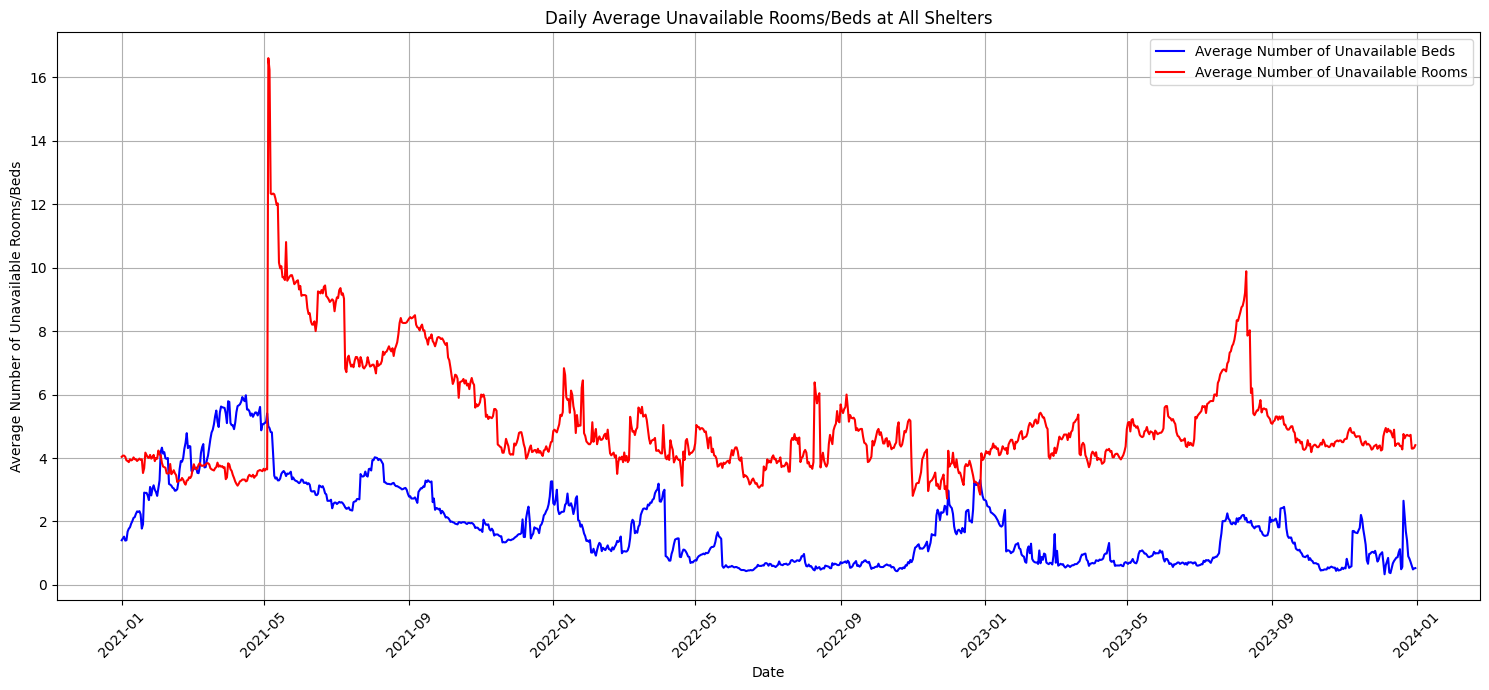

In [125]:
# PLOTTING UNAVAILABILITY TO VISUALIZE -----------------------------------------

# Calculate daily average occupancy rate for beds
daily_avg_unav_bed = bed_capacity_df.groupby('OCCUPANCY_DATE')['UNAVAILABLE_BEDS'].mean().reset_index()

# Calculate daily average occupancy rate for rooms
daily_avg_unav_room = room_capacity_df.groupby('OCCUPANCY_DATE')['UNAVAILABLE_ROOMS'].mean().reset_index()

# Plotting
plt.figure(figsize=(15, 7))

# Plot for beds
plt.plot(daily_avg_unav_bed['OCCUPANCY_DATE'], daily_avg_unav_bed['UNAVAILABLE_BEDS'], label='Average Number of Unavailable Beds', color='blue')

# Plot for rooms
plt.plot(daily_avg_unav_room['OCCUPANCY_DATE'], daily_avg_unav_room['UNAVAILABLE_ROOMS'], label='Average Number of Unavailable Rooms', color='red')

plt.title('Daily Average Unavailable Rooms/Beds at All Shelters')
plt.xlabel('Date')
plt.ylabel('Average Number of Unavailable Rooms/Beds')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()

plt.show()

## 2. Weather Data

In [126]:
weather_file_paths = ['/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2021_P1D.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2022_P1D.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2023_P1D.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2024_P1D.csv']

dataframes = [pd.read_csv(file) for file in weather_file_paths]

for file in weather_file_paths:
    try:
        weather_df = pd.read_csv(file)
        if df.empty:
            print(f"The file at {file} is empty.")
        else:
            print(f"Loaded {len(weather_df)} rows from {file}")
            dataframes.append(weather_df)
    except FileNotFoundError:
        print(f"No file found at {file}")
    except pd.errors.EmptyDataError:
        print(f"File at {file} is empty or corrupted.")

if dataframes:
    combined_weather_df = pd.concat(dataframes, ignore_index=True)
    print(f"The combined dataframe has {len(combined_weather_df)} rows.")
else:
    print("No data has been loaded. Please check the file paths and contents.")

Loaded 365 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2021_P1D.csv
Loaded 365 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2022_P1D.csv
Loaded 365 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2023_P1D.csv
Loaded 366 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2024_P1D.csv
The combined dataframe has 2922 rows.


In [127]:
# Removing unnecessary columns
columns_to_drop = ['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Data Quality', 'Max Temp Flag', 'Min Temp Flag', 'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag']

weather_df = combined_weather_df.drop(columns_to_drop, axis=1)

print(weather_df.head())

    Date/Time  Year  Month  Day  Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  \
0  2021-01-01  2021      1    1            2.5           -1.0             0.7   
1  2021-01-02  2021      1    2            2.2           -0.9             0.7   
2  2021-01-03  2021      1    3            2.1            0.2             1.1   
3  2021-01-04  2021      1    4            1.7           -0.1             0.8   
4  2021-01-05  2021      1    5            1.6            0.6             1.1   

   Total Precip (mm)  
0                6.8  
1               10.8  
2                1.7  
3                0.0  
4                0.4  


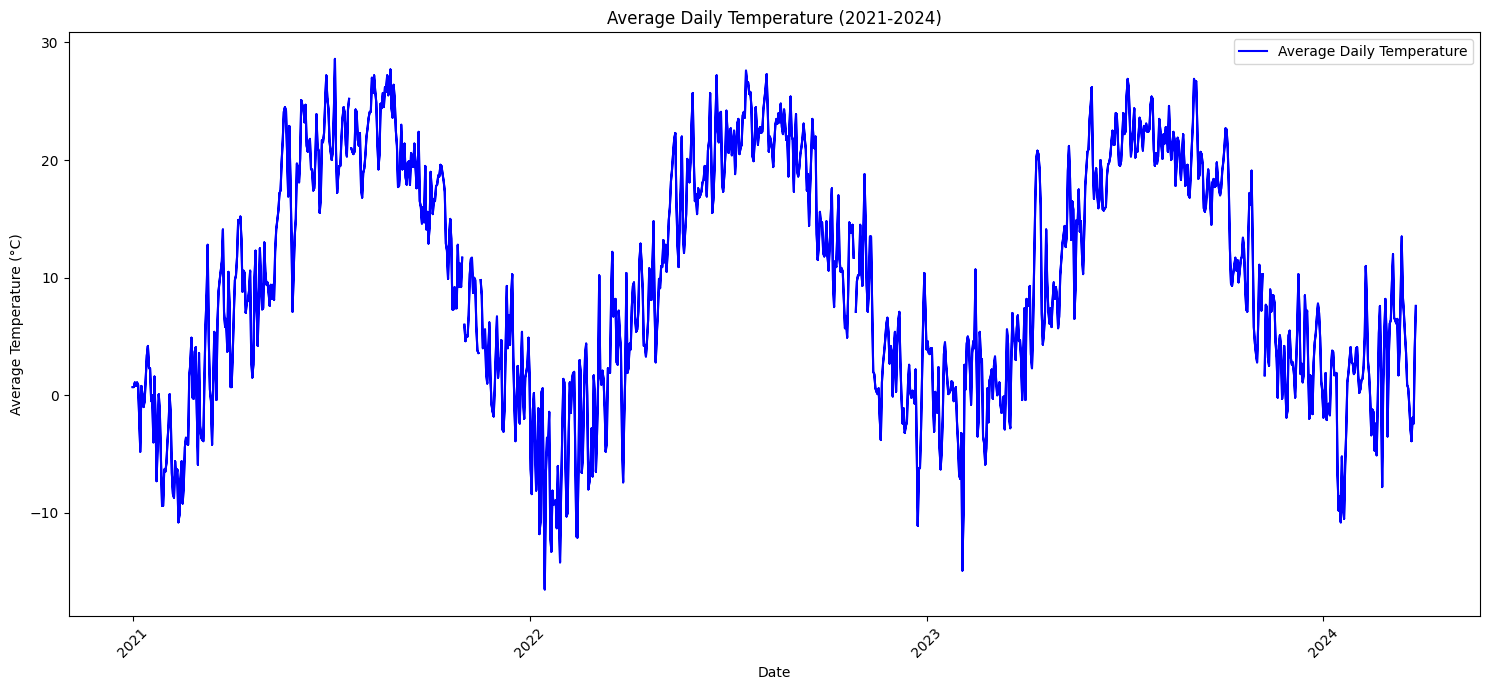

In [128]:
# PLOTTING DAILY AVERAGE TEMPERATURE -----------------------------------------

weather_df['Date/Time'] = pd.to_datetime(weather_df['Date/Time'])

register_matplotlib_converters()

plt.figure(figsize=(15, 7))

plt.plot(weather_df['Date/Time'], weather_df['Mean Temp (°C)'], label='Average Daily Temperature', color='blue')

plt.title('Average Daily Temperature (2021-2024)')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend()

# Set the locator for major ticks to show one tick per year and format it to show the year only
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()

plt.show()


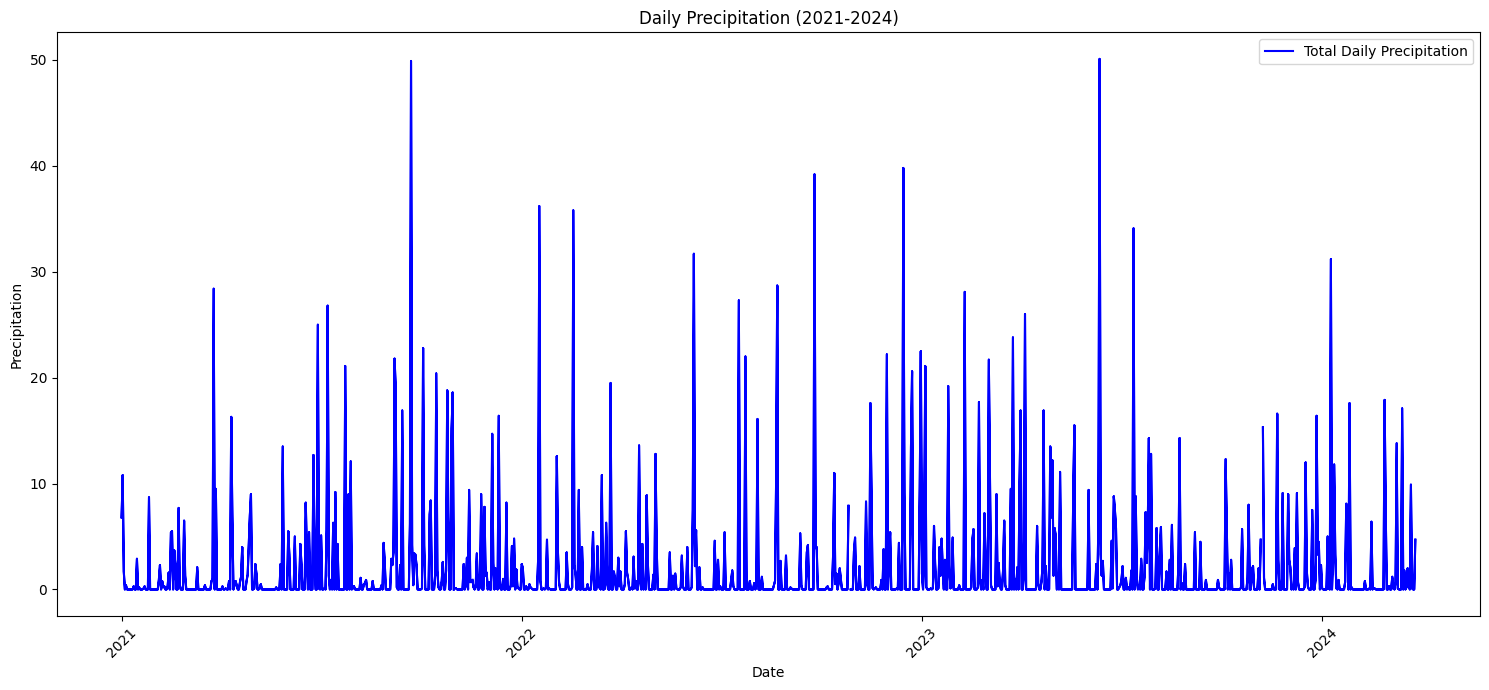

In [129]:
# PLOTTING DAILY PRECIPITATION TEMPERATURE -----------------------------------------

weather_df['Date/Time'] = pd.to_datetime(weather_df['Date/Time'])

register_matplotlib_converters()

plt.figure(figsize=(15, 7))

plt.plot(weather_df['Date/Time'], weather_df['Total Precip (mm)'], label='Total Daily Precipitation', color='blue')

plt.title('Daily Precipitation (2021-2024)')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend()

# Set the locator for major ticks to show one tick per year and format it to show the year only
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()

plt.show()


## 3. Housing Information

In [130]:
housing_file_path = '/content/drive/MyDrive/Colab Notebooks/Borealis Project/Housing.csv'

housing_df = pd.read_csv(housing_file_path)

print(housing_df.head())

  REF_DATE              GEO           DGUID New housing price indexes  \
0  1981-01           Canada  2016A000011124    Total (house and land)   
1  1981-01           Canada  2016A000011124                House only   
2  1981-01           Canada  2016A000011124                 Land only   
3  1981-01  Atlantic Region      2016A00011    Total (house and land)   
4  1981-01  Atlantic Region      2016A00011                House only   

                 UOM  UOM_ID SCALAR_FACTOR  SCALAR_ID      VECTOR  COORDINATE  \
0  Index, 201612=100     347         units          0  v111955442         1.1   
1  Index, 201612=100     347         units          0  v111955443         1.2   
2  Index, 201612=100     347         units          0  v111955444         1.3   
3  Index, 201612=100     347         units          0  v111955445         2.1   
4  Index, 201612=100     347         units          0  v111955446         2.2   

   VALUE STATUS  SYMBOL  TERMINATED  DECIMALS  
0   38.2    NaN     NaN   

In [131]:
toronto_housing_df = housing_df[housing_df['GEO'].str.contains('Toronto, Ontario', na=False)]
house_df = toronto_housing_df[toronto_housing_df['New housing price indexes'] == 'Total (house and land)']

# Ensure 'REF_DATE' is in datetime format
house_df['REF_DATE'] = pd.to_datetime(house_df['REF_DATE'])

house_df = house_df[~((house_df['REF_DATE'].dt.year >= 1981) & (house_df['REF_DATE'].dt.year <= 2010))]

columns_to_drop = ['DGUID', 'UOM', 'SCALAR_FACTOR', 'UOM_ID', 'New housing price indexes', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS']

house_df = house_df.drop(columns_to_drop, axis=1)

print(house_df.head())

        REF_DATE               GEO  VALUE
43257 2011-01-01  Toronto, Ontario   77.7
43377 2011-02-01  Toronto, Ontario   78.1
43497 2011-03-01  Toronto, Ontario   78.4
43617 2011-04-01  Toronto, Ontario   78.8
43737 2011-05-01  Toronto, Ontario   79.6


<ipython-input-131-d0c4b2fc5e64>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df['REF_DATE'] = pd.to_datetime(house_df['REF_DATE'])


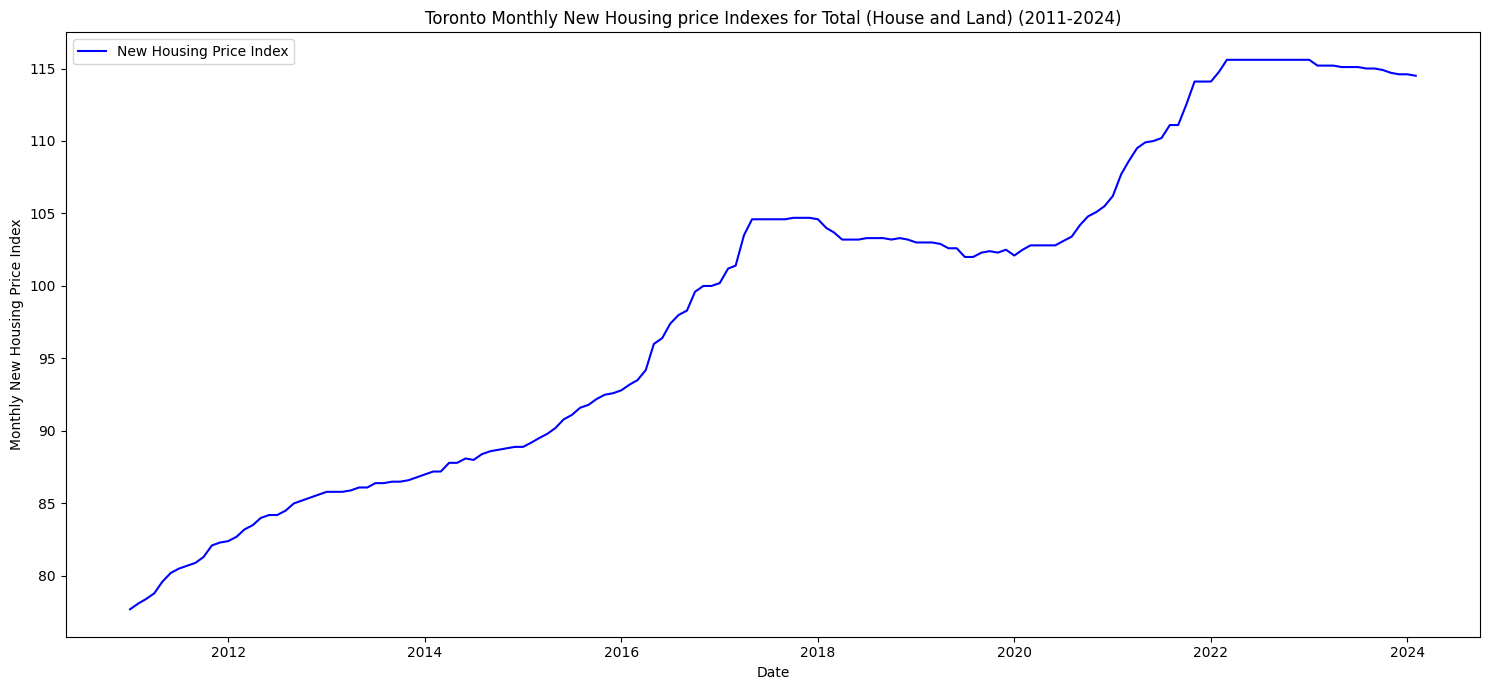

In [132]:
# PLOTTING MONTHLY NEW HOUSING PRICE INDEXES -----------------------------------------

house_df['REF_DATE'] = pd.to_datetime(house_df['REF_DATE'])

register_matplotlib_converters()

plt.figure(figsize=(15, 7))

plt.plot(house_df['REF_DATE'], house_df['VALUE'], label='New Housing Price Index', color='blue')

plt.title('Toronto Monthly New Housing price Indexes for Total (House and Land) (2011-2024)')
plt.xlabel('Date')
plt.ylabel('Monthly New Housing Price Index')
plt.legend()

plt.tight_layout()

plt.show()


# Understanding Correlation

### Combining the Datasets

In [133]:
# columns_to_drop = ['CAPACITY_FUNDING_ROOM', 'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS', 'CAPACITY_ACTUAL_ROOM', 'UNAVAILABLE_ROOMS']
# room_capacity_df = room_capacity_df.drop(columns_to_drop, axis=1)

# Merge shelter_data and weather_data on the date
merged_data = pd.merge(room_capacity_df, weather_df, left_on='OCCUPANCY_DATE', right_on='Date/Time', how='left')

# Merging with housing data
merged_data['YEAR_MONTH'] = merged_data['OCCUPANCY_DATE'].dt.to_period('M')
house_df['YEAR_MONTH'] = house_df['REF_DATE'].dt.to_period('M')
final_merged_data = pd.merge(merged_data, house_df, on='YEAR_MONTH', how='left')

# Selecting relevant columns, assuming you might not need all the merged columns
final_data = final_merged_data[['OCCUPANCY_DATE', 'OCCUPANCY_RATE_ROOMS', 'LOCATION_ID', 'ORGANIZATION_ID', 'LOCATION_POSTAL_CODE', 'Mean Temp (°C)', 'Total Precip (mm)', 'VALUE']]

# Renaming columns for standard look
final_data.rename(columns={'Mean Temp (°C)': 'AVG_TEMP', 'Total Precip (mm)': 'TOTAL_PRECIP', 'VALUE': 'HOUSING_PRICE_INDEX'}, inplace=True)

# Label Encoding
label_encoder = LabelEncoder()

final_data['LOCATION_POSTAL_CODE'] = label_encoder.fit_transform(final_data['LOCATION_POSTAL_CODE'])

print(final_data.head())

  OCCUPANCY_DATE  OCCUPANCY_RATE_ROOMS  LOCATION_ID  ORGANIZATION_ID  \
0     2021-01-01                 89.66       1103.0               24   
1     2021-01-01                 89.66       1103.0               24   
2     2021-01-01                100.00       1103.0               24   
3     2021-01-01                100.00       1103.0               24   
4     2021-01-01                 82.14       1103.0               24   

   LOCATION_POSTAL_CODE  AVG_TEMP  TOTAL_PRECIP  HOUSING_PRICE_INDEX  
0                    13       0.7           6.8                106.2  
1                    13       0.7           6.8                106.2  
2                    13       0.7           6.8                106.2  
3                    13       0.7           6.8                106.2  
4                    13       0.7           6.8                106.2  


<ipython-input-133-5e858aa438c5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data.rename(columns={'Mean Temp (°C)': 'AVG_TEMP', 'Total Precip (mm)': 'TOTAL_PRECIP', 'VALUE': 'HOUSING_PRICE_INDEX'}, inplace=True)
<ipython-input-133-5e858aa438c5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['LOCATION_POSTAL_CODE'] = label_encoder.fit_transform(final_data['LOCATION_POSTAL_CODE'])


### Basic Stats

In [134]:
# Display basic statistics
print(final_data.describe())

                      OCCUPANCY_DATE  OCCUPANCY_RATE_ROOMS    LOCATION_ID  \
count                         205772         205772.000000  204968.000000   
mean   2022-06-05 19:16:28.052796672             96.532977    1142.481773   
min              2021-01-01 00:00:00              1.200000    1001.000000   
25%              2021-09-03 00:00:00             99.320000    1103.000000   
50%              2022-05-30 00:00:00            100.000000    1160.000000   
75%              2023-02-25 00:00:00            100.000000    1179.000000   
max              2023-12-31 00:00:00            101.410000    1320.000000   
std                              NaN             11.759191      56.768147   

       ORGANIZATION_ID  LOCATION_POSTAL_CODE       AVG_TEMP   TOTAL_PRECIP  \
count    205772.000000         205772.000000  204856.000000  204856.000000   
mean         11.025193             19.677624      10.444953       2.107713   
min           1.000000              0.000000     -16.500000       0.0000

### Visualizations of the Data and the Relationships

In [135]:
# Calculate and display the correlation matrix
correlation_matrix = final_data[['OCCUPANCY_RATE_ROOMS', 'AVG_TEMP', 'TOTAL_PRECIP', 'HOUSING_PRICE_INDEX']].corr()
print(correlation_matrix)

                      OCCUPANCY_RATE_ROOMS  AVG_TEMP  TOTAL_PRECIP  \
OCCUPANCY_RATE_ROOMS              1.000000 -0.016959      0.001721   
AVG_TEMP                         -0.016959  1.000000      0.020208   
TOTAL_PRECIP                      0.001721  0.020208      1.000000   
HOUSING_PRICE_INDEX               0.172974  0.093199      0.029730   

                      HOUSING_PRICE_INDEX  
OCCUPANCY_RATE_ROOMS             0.172974  
AVG_TEMP                         0.093199  
TOTAL_PRECIP                     0.029730  
HOUSING_PRICE_INDEX              1.000000  


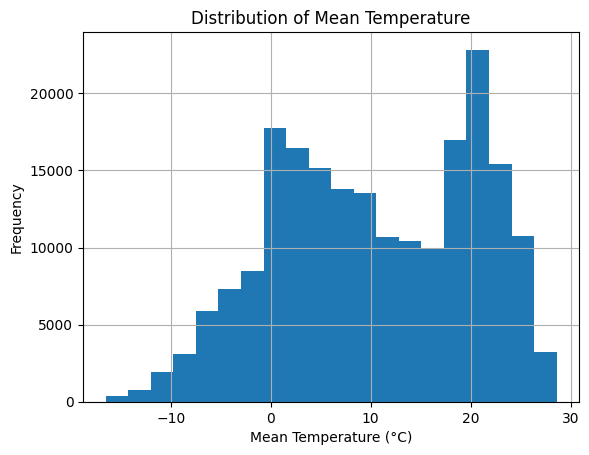

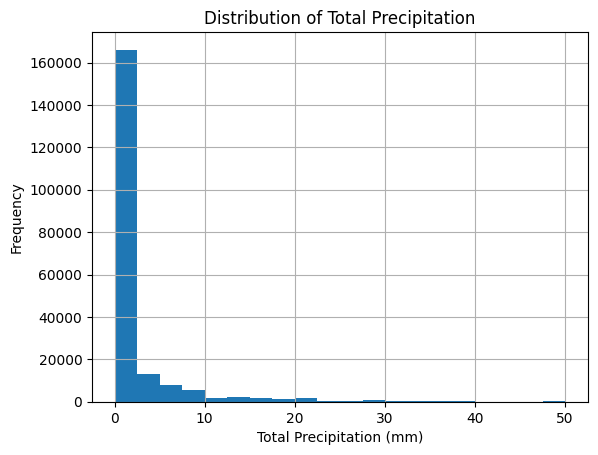

In [136]:
# Histogram for Mean Temperature
final_data['AVG_TEMP'].hist(bins=20)
plt.title('Distribution of Mean Temperature')
plt.xlabel('Mean Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

# Histogram for Total Precipitation
final_data['TOTAL_PRECIP'].hist(bins=20)
plt.title('Distribution of Total Precipitation')
plt.xlabel('Total Precipitation (mm)')
plt.ylabel('Frequency')
plt.show()

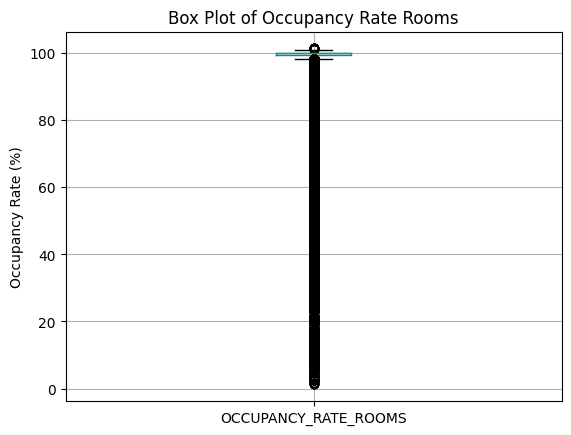

In [137]:
# Box plot for occupancy rates
final_data.boxplot(column=['OCCUPANCY_RATE_ROOMS'])
plt.title('Box Plot of Occupancy Rate Rooms')
plt.ylabel('Occupancy Rate (%)')
plt.show()

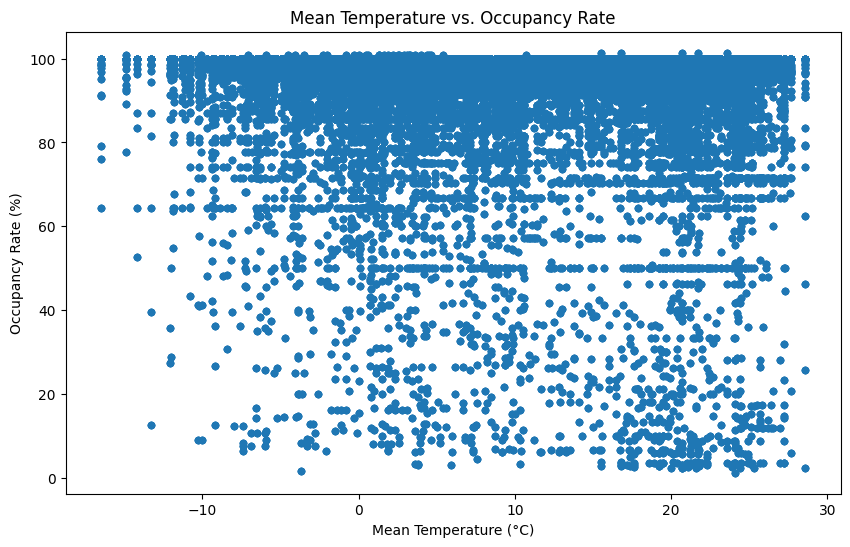

In [138]:
# Scatter plot of Mean Temperature vs. Occupancy Rate
final_data.plot.scatter(x='AVG_TEMP', y='OCCUPANCY_RATE_ROOMS', figsize=(10, 6))
plt.title('Mean Temperature vs. Occupancy Rate')
plt.xlabel('Mean Temperature (°C)')
plt.ylabel('Occupancy Rate (%)')
plt.show()

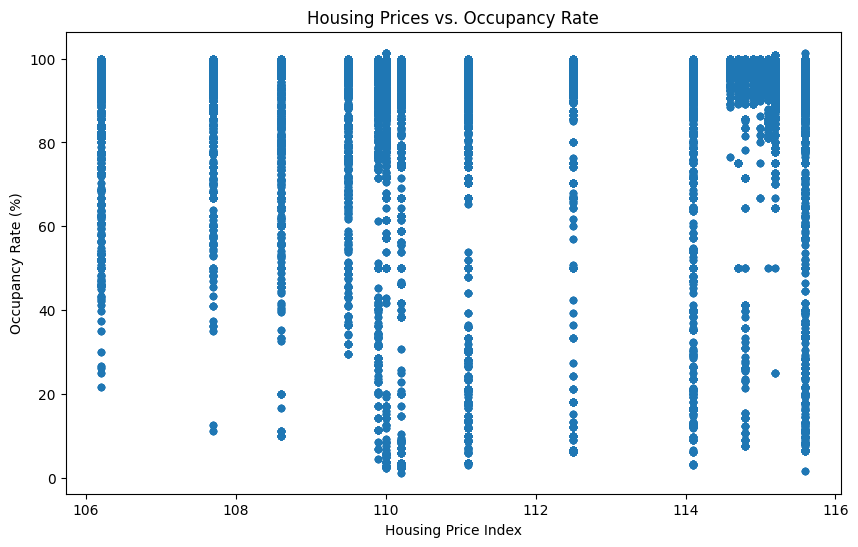

In [139]:
# Scatter plot of Housing Prices (VALUE) vs. Occupancy Rate
final_data.plot.scatter(x='HOUSING_PRICE_INDEX', y='OCCUPANCY_RATE_ROOMS', figsize=(10, 6))
plt.title('Housing Prices vs. Occupancy Rate')
plt.xlabel('Housing Price Index')
plt.ylabel('Occupancy Rate (%)')
plt.show()

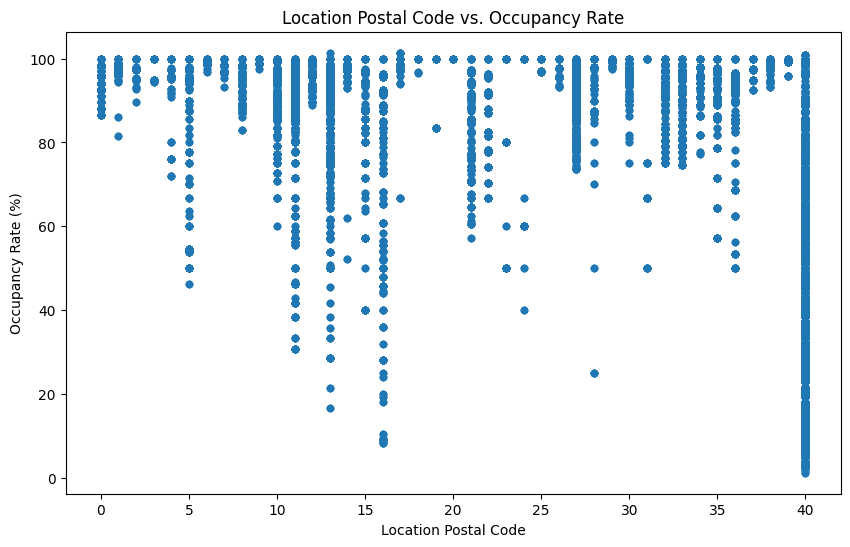

In [140]:
# Scatter plot of Housing Prices (VALUE) vs. Occupancy Rate
final_data.plot.scatter(x='LOCATION_POSTAL_CODE', y='OCCUPANCY_RATE_ROOMS', figsize=(10, 6))
plt.title('Location Postal Code vs. Occupancy Rate')
plt.xlabel('Location Postal Code')
plt.ylabel('Occupancy Rate (%)')
plt.show()


In [141]:
# !pip install seaborn

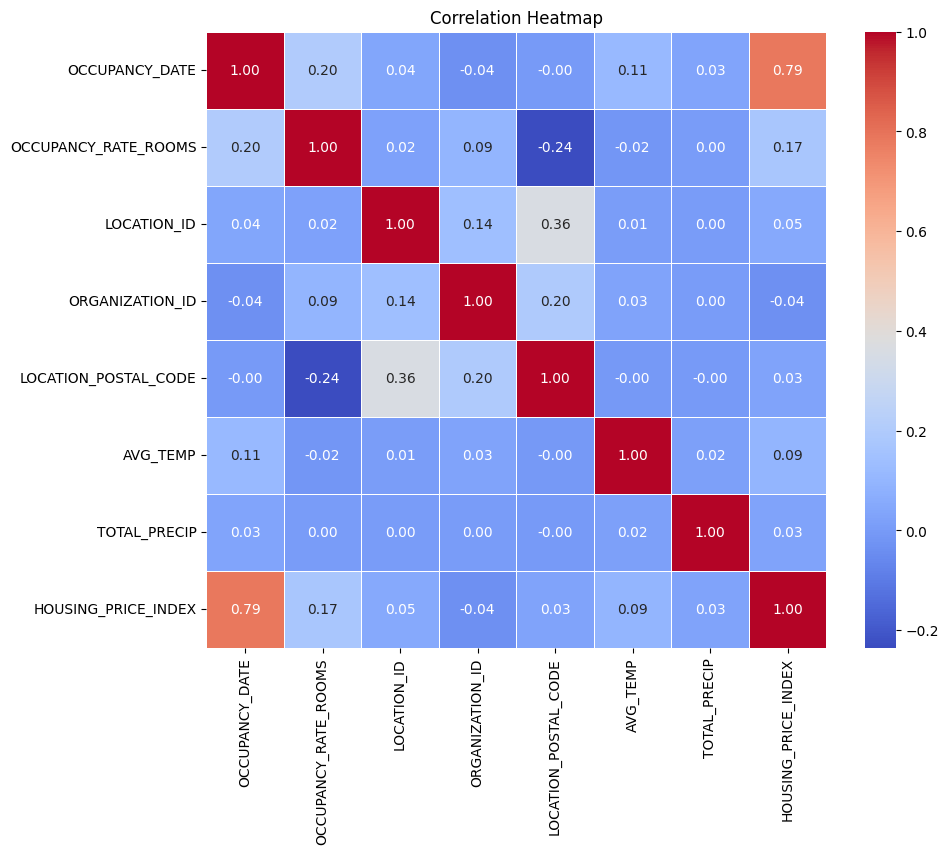

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'final_data' is your DataFrame and 'OCCUPANCY_RATE_ROOMS' is the target variable
# First, calculate the correlation matrix for your dataset
correlation_matrix = final_data.corr()

# Use seaborn to create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


### Heatmap for Avg Dataset

  OCCUPANCY_DATE  OCCUPANCY_RATE_ROOMS  Date/Time  Year  Month  Day  \
0     2021-01-01             93.023019 2021-01-01  2021      1    1   
1     2021-01-01             93.023019 2021-01-01  2021      1    1   
2     2021-01-02             93.259811 2021-01-02  2021      1    2   
3     2021-01-02             93.259811 2021-01-02  2021      1    2   
4     2021-01-03             93.257736 2021-01-03  2021      1    3   

   Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  Total Precip (mm) YEAR_MONTH  \
0            2.5           -1.0             0.7                6.8    2021-01   
1            2.5           -1.0             0.7                6.8    2021-01   
2            2.2           -0.9             0.7               10.8    2021-01   
3            2.2           -0.9             0.7               10.8    2021-01   
4            2.1            0.2             1.1                1.7    2021-01   

    REF_DATE               GEO  VALUE  
0 2021-01-01  Toronto, Ontario  106.2  
1 2021

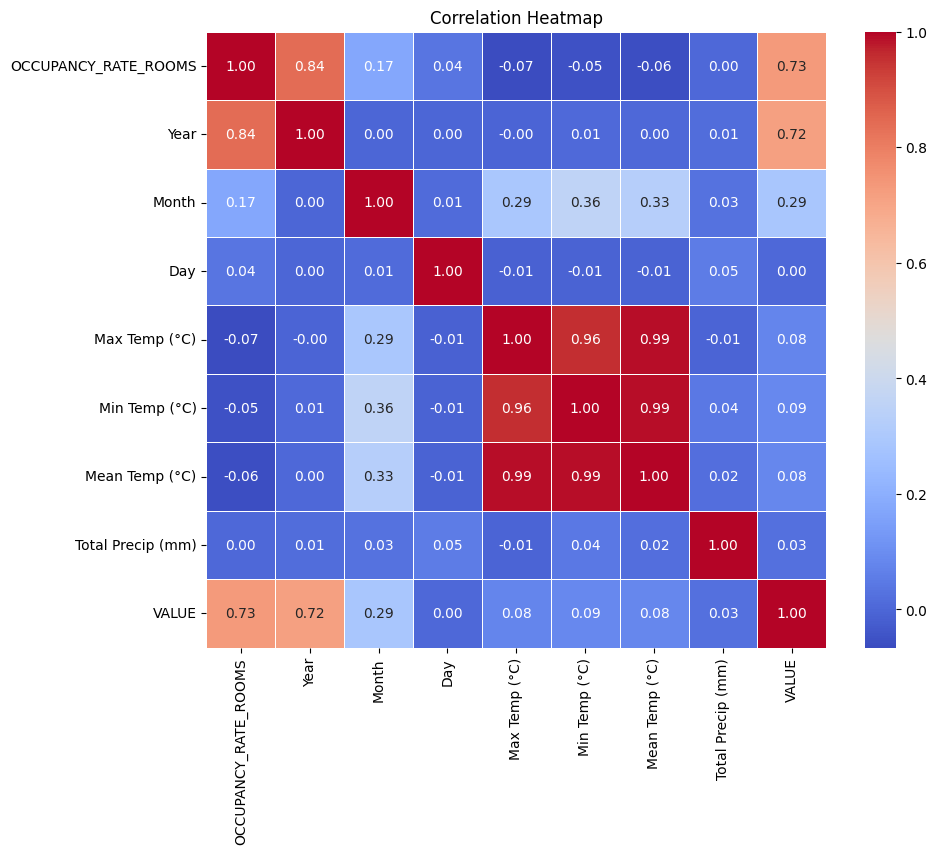

In [151]:
avg_final_data = final_data.groupby('OCCUPANCY_DATE')['OCCUPANCY_RATE_ROOMS'].mean().reset_index()

avg_final_merged = pd.merge(avg_final_data, weather_df, left_on='OCCUPANCY_DATE', right_on='Date/Time', how='left')

# Merging with housing data
avg_final_merged['YEAR_MONTH'] = avg_final_merged['OCCUPANCY_DATE'].dt.to_period('M')
house_df['YEAR_MONTH'] = house_df['REF_DATE'].dt.to_period('M')
final_avg_merged_data = pd.merge(avg_final_merged, house_df, on='YEAR_MONTH', how='left')

print(final_avg_merged_data.head())

relevant_columns = ['OCCUPANCY_RATE_ROOMS', 'Year', 'Month', 'Day',
                    'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
                    'Total Precip (mm)', 'VALUE']

correlation_matrix = final_avg_merged_data[relevant_columns].corr()

# Use seaborn to create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as necessary
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

### Heatmap for just one shelter

In [144]:
specific_shelter_df = final_data[final_data['LOCATION_ID'] == 1103.0]
print(specific_shelter_df.head())
print(specific_shelter_df.shape[0])

  OCCUPANCY_DATE  OCCUPANCY_RATE_ROOMS  LOCATION_ID  ORGANIZATION_ID  \
0     2021-01-01                 89.66       1103.0               24   
1     2021-01-01                 89.66       1103.0               24   
2     2021-01-01                100.00       1103.0               24   
3     2021-01-01                100.00       1103.0               24   
4     2021-01-01                 82.14       1103.0               24   

   LOCATION_POSTAL_CODE  AVG_TEMP  TOTAL_PRECIP  HOUSING_PRICE_INDEX  
0                    13       0.7           6.8                106.2  
1                    13       0.7           6.8                106.2  
2                    13       0.7           6.8                106.2  
3                    13       0.7           6.8                106.2  
4                    13       0.7           6.8                106.2  
19488


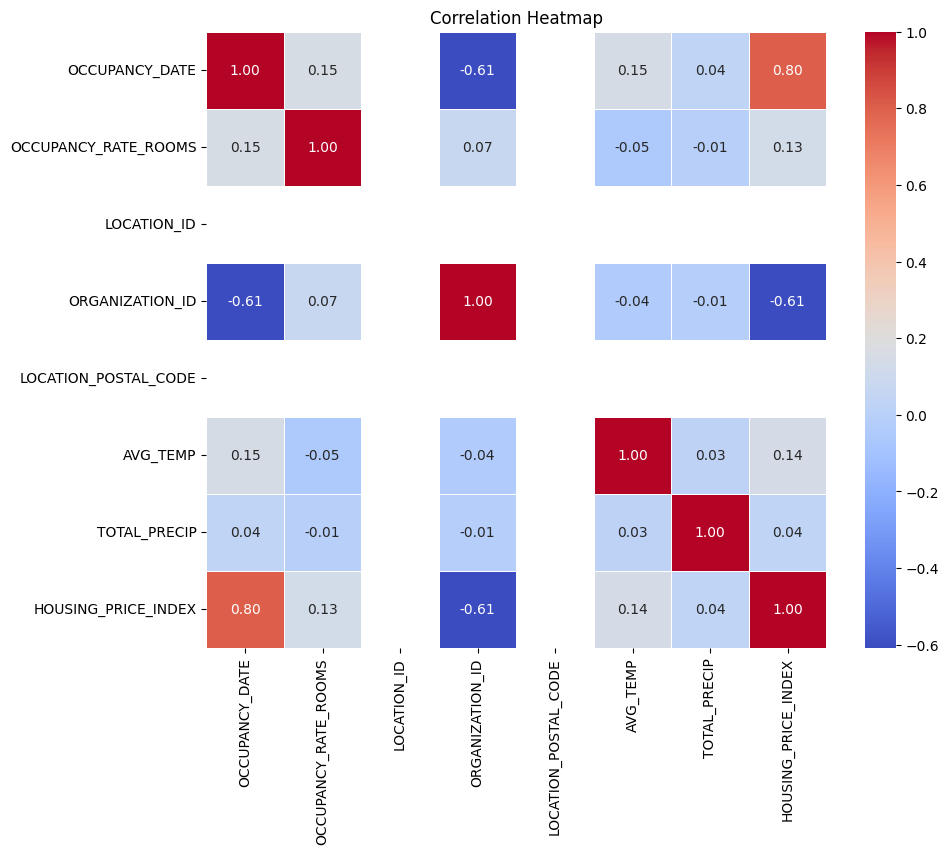

In [119]:
correlation_matrix = specific_shelter_df.corr()

# Use seaborn to create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()
